In [1]:
import sys
sys.path.append('..')
import os
import json

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import numpy as np

import torch
import torch.nn.functional as F

from models import get_net
from utils.denoising_utils import *
from utils.common_utils import np_to_pil, pil_to_np, get_fname

from BayTorch.freq_to_bayes import MCDropoutVI, MeanFieldVI
from BayTorch.inference.losses import uceloss
from BayTorch.inference.utils import uncert_regression_gal
import BayTorch.visualize as V

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{bm}']

In [2]:
def get_trained_net(net_info, train_data):
    bay_inf_type = net_info['bay_inf_type']
    
    net = get_net(net_info['num_input_channels'], 'skip', 'reflection',
              skip_n33d=net_info['num_channels_down'],
              skip_n33u=net_info['num_channels_up'],
              skip_n11=net_info['num_channels_skip'],
              num_scales=net_info['num_scales'],
              n_channels=net_info['num_output_channels'],
              upsample_mode=net_info['upsample_mode'],
              need_sigmoid=False)

    #optimizer = torch.optim.AdamW(net.parameters(), lr=net_info['lr'])
    
    if bay_inf_type == 'mc_dropout':
        net = MCDropoutVI(net, net_info['dropout_type'], net_info['dropout_p'])
    elif bay_inf_type == 'mean_field':
        prior = {'mu': net_info['prior_mu'], 'sigma': net_info['prior_sigma']}
        if net_info['prior_pi'] is not None:
            prior['pi'] = net_info['prior_pi']
        net = MeanFieldVI(net, prior=prior, kl_type=net_info['kl_type'])
    
    net.load_state_dict(train_data['state_dict'])
    return net.type(dtype)

In [3]:
#path_log_dir = '/home/toelle/logs'
path_log_dir = '/media/fastdata/toelle/logs'

to_compare = 'ct'

if to_compare == 'dropout_ps':
    # dropout ps
    run = 'mc_dropout_den_xray_2d_p'
    runs = ['%s_01' % run, '%s_02' % run, 'mc_dropout_den_xray_2d', '%s_04' % run, '%s_05' % run, 
            '%s_07' % run, '%s_09' % run]
    label = 'MCD 2d'
    labels = ['%s 0.1' % label, '%s 0.2' % label, '%s 0.3' % label, '%s 0.4' % label, '%s 0.5' % label, 
              '%s 0.7' % label, '%s 0.9' % label]

elif to_compare == 'sgld_uncert':
    runs = ['sgld_den_xray_uncert', 'sgld_den_us_uncert', 'sgld_den_oct_uncert', 'sgld_den_mri_uncert', 'sgld_den_ct_uncert']
    labels = runs
    
elif to_compare == 'sgld_uncert_nll':
    runs = [#'sgld_den_xray_nll_uncert', 
            'sgld_den_us_nll_uncert', 'sgld_den_oct_nll_uncert', 
            'sgld_den_mri_nll_uncert', 'sgld_den_ct_nll_uncert']
    labels = runs

elif to_compare == 'sgld_paper_uncert':
    runs = ['sgld_paper_den_xray_uncert', 'sgld_paper_den_us_uncert', 'sgld_paper_den_oct_uncert', 
            'sgld_paper_den_mri_uncert', 'sgld_paper_den_ct_uncert']
    labels = runs
    
elif to_compare == 'sgld_paper_uncert_nll':
    runs = [#'sgld_den_xray_nll_uncert', 
            'sgld_den_us_nll_uncert', 'sgld_den_oct_nll_uncert', 
            'sgld_den_mri_nll_uncert', 'sgld_den_ct_nll_uncert']
    labels = runs

elif to_compare == 'kl_weights':
    # kl weights
    runs = ['mean_field_den_xray_standard_reverse', 'mean_field_den_xray_blundell_reverse', 
            'mean_field_den_xray_linear_reverse', 'mean_field_den_xray_no_params_reverse',
            'mean_field_den_xray_soenderby_reverse', 'mean_field_den_xray_1e-2_reverse',
            'mean_field_den_xray_1e-4_reverse', 'mean_field_den_xray_1e-6_reverse',
            'mean_field_den_xray_1e-8_reverse', 'mean_field_den_xray_0']
    labels = [r'Standard', r'Blundell', r'Linear', r'No. params', r'Soenderby', r'$1e-2$', r'$1e-4$', 
              r'$1e-6$', r'$1e-8$', r'$0$']

elif to_compare == 'xray':
    # compare all xray
    runs = ['none_den_xray_mcd_specs', 
            'mean_field_den_xray_1e-6_reverse_2', 'mean_field_den_xray_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_xray_2d_1', 'mc_dropout_den_xray_g2d_1',
            'sgld_den_xray_uncert', 'sgld_den_xray_nll_uncert_1',
            'sgld_paper_den_xray_uncert', 'sgld_paper_den_xray_nll_uncert_2'
           ]
            #'sgld_den_xray_mse_mcd_specs', 'sgld_den_xray_nll_mcd_specs', 'sgld_paper_den_xray_mcd_specs',
            #'sgld_paper_den_xray_nll_mcd_specs'] # xray sgld den mcd specs mse
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2d', r'MCD g2d', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']

elif to_compare == 'us':
    # compare all us
    runs = ['none_den_us_mcd_specs', 
            'mean_field_den_us_1e-6_reverse_2', 'mean_field_den_us_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_us_2d_1', 'mc_dropout_den_us_g2d_1', 
            'sgld_den_us_uncert', 'sgld_den_us_nll_uncert',
            'sgld_paper_den_us_uncert', 'sgld_paper_den_us_nll_uncert'
            #'sgld_den_us_mse_mcd_specs', 'sgld_den_us_nll_mcd_specs', 'sgld_paper_den_us_mcd_specs',
            #'sgld_paper_den_us_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2d', r'MCD g2d', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


elif to_compare == 'oct':
    # compare all oct
    runs = ['none_den_oct_mcd_specs', 
            'mean_field_den_oct_1e-6_reverse_2', 'mean_field_den_oct_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_oct_2d_1', 'mc_dropout_den_oct_g2d_1', 
            'sgld_den_oct_uncert', 'sgld_den_oct_nll_uncert',
            'sgld_paper_den_oct_uncert', 'sgld_paper_den_oct_nll_uncert'
            #'sgld_den_oct_mse_mcd_specs', 'sgld_den_oct_nll_mcd_specs', 'sgld_paper_den_oct_mcd_specs',
            #'sgld_paper_den_oct_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2d', r'MCD g2d', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


elif to_compare == 'mri':
    # compare all mri
    runs = ['none_den_mri_mcd_specs', 
            'mean_field_den_mri_1e-6_reverse_1', 'mean_field_den_mri_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_mri_2d_1', 'mc_dropout_den_mri_g2d_1', 
            'sgld_den_mri_uncert', 'sgld_den_mri_nll_uncert',
            'sgld_paper_den_mri_uncert', 'sgld_paper_den_mri_nll_uncert'
            #'sgld_den_mri_mse_mcd_specs', 'sgld_den_mri_nll_mcd_specs', 'sgld_paper_den_mri_mcd_specs',
            #'sgld_paper_den_mri_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2d', r'MCD g2d', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


elif to_compare == 'ct':
    # compare all ct
    runs = ['none_den_ct_mcd_specs', 
            'mean_field_den_ct_1e-6_reverse_1', 'mean_field_den_ct_1e-6_forward_smp_100_0001_05_05', 
            'mc_dropout_den_ct_2d_1', 'mc_dropout_den_ct_g2d_1', 
            'sgld_den_ct_uncert', 'sgld_den_ct_nll_uncert',
            'sgld_paper_den_ct_uncert', 'sgld_paper_den_ct_nll_uncert'
            #'sgld_den_ct_mse_mcd_specs', 'sgld_den_ct_nll_mcd_specs', 'sgld_paper_den_ct_mcd_specs',
            #'sgld_paper_den_ct_nll_mcd_specs'
            ]
    labels = [r'DIP', r'FFG GP', r'FFG SMP', 
              r'MCD 2d', r'MCD g2d', r'SGLD+MSE $\sigma^2=\eta$', 
              r'SGLD+NLL $\sigma^2=\eta$', r'SGLD+MSE $\sigma=\eta$', r'SGLD+NLL $\sigma=\eta$']


# smp


elif to_compare == 'sigmas':
    # sigmas
    run = 'mean_field_den_xray_1e-6_reverse_sigma'
    runs = ['%s_001' % run, '%s_005' % run, 'mean_field_den_xray_1e-6_reverse', '%s_015' % run, '%s_02' % run, 
            '%s_025' % run, '%s_05' % run]
    labels = [r'$\sigma = 0.01$', r'$\sigma = 0.05$', r'$\sigma = 0.1$', r'$\sigma = 0.15$', r'$\sigma = 0.2$', 
              r'$\sigma = 0.25$', r'$\sigma = 0.5$']

# reverse / forward


# reverse / forward smp


# sgld

In [4]:
files = os.listdir(path_log_dir)
mc_iter = 10

['none_den_ct_mcd_specs']


/home/laves/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(1, 50000)
DIP
max psnr: 26.59
1430
26.19241519012761
max psnr last 100: 21.89
mean psnr: 21.86
std psnr: 0.0116


max ssim: 0.88
max ssim last 100: 0.61
mean ssim: 0.61
std ssim: 0.0005


mean mse: 0.00004
std: 0.0000


uncert mean: 93.11345
uncert std: 0.00000
uce mean: 8669.63625
uce std: 0.00000



['mean_field_den_ct_1e-6_reverse_1']
(1, 50000)
FFG GP
max psnr: 27.42
25217
24.545842330654402
max psnr last 100: 27.32
mean psnr: 27.32
std psnr: 0.0016


max ssim: 0.88
max ssim last 100: 0.88
mean ssim: 0.88
std ssim: 0.0001


mean mse: 0.00558
std: 0.0000


uncert mean: 7.71811
uncert std: 0.23050
uce mean: 6.91051
uce std: 0.12246



['mean_field_den_ct_1e-6_forward_smp_100_0001_05_05']
(1, 50000)
FFG SMP
max psnr: 27.39
18210
24.81803463983814
max psnr last 100: 26.17
mean psnr: 26.03
std psnr: 0.0857


max ssim: 0.88
max ssim last 100: 0.81
mean ssim: 0.81
std ssim: 0.0038


mean mse: 0.00683
std: 0.0001


uncert mean: 8.25696
uncert std: 0.15653
uce mean: 2.82758
uce std: 0.2471

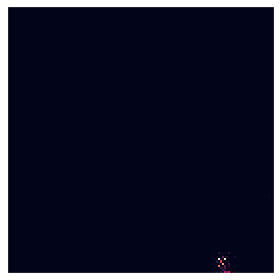

0.011289095506072044


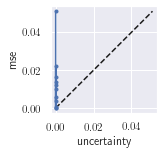

(1, 50000)
SGLD+MSE $\sigma^2=\eta$
max psnr: 14.18
165
12.752516994414375
max psnr last 100: 12.75
mean psnr: 12.75
std psnr: 0.0001


max ssim: 0.47
max ssim last 100: 0.47
mean ssim: 0.47
std ssim: 0.0000


mean mse: 0.06018
std: 0.0002


uncert mean: 0.01549
uncert std: 0.00000
uce mean: 112.89096
uce std: 0.00000



['sgld_den_ct_nll_uncert']


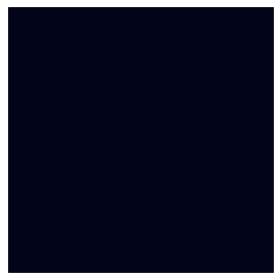

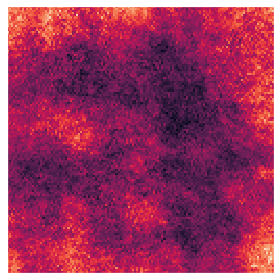

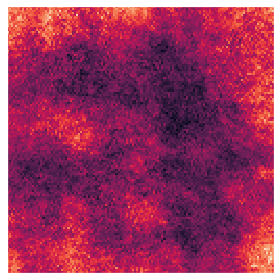

0.12091128528118134


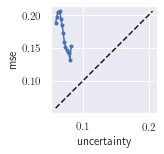

(1, 50000)
SGLD+NLL $\sigma^2=\eta$
max psnr: 15.58
1085
15.211892527058206
max psnr last 100: 4.20
mean psnr: 3.91
std psnr: 0.1209


max ssim: 0.47
max ssim last 100: 0.47
mean ssim: 0.46
std ssim: 0.0027


mean mse: 0.46199
std: 0.0328


uncert mean: 26.03493
uncert std: 0.00000
uce mean: 1209.11285
uce std: 0.00000



['sgld_paper_den_ct_uncert']
float32
0.008230611
0.0005293477


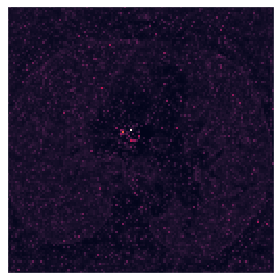

9.97749884845689e-05


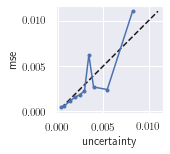

(1, 50000)
SGLD+MSE $\sigma=\eta$
max psnr: 27.56
4009
25.27576993384292
max psnr last 100: 22.48
mean psnr: 22.48
std psnr: 0.0026


max ssim: 0.87
max ssim last 100: 0.64
mean ssim: 0.64
std ssim: 0.0002


mean mse: 0.00074
std: 0.0000


uncert mean: 2.30076
uncert std: 0.00000
uce mean: 0.99775
uce std: 0.00000



['sgld_paper_den_ct_nll_uncert']


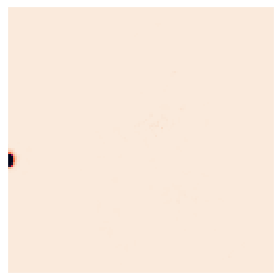

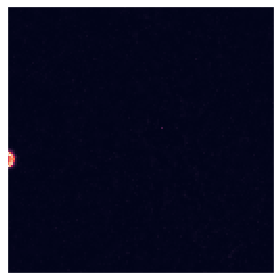

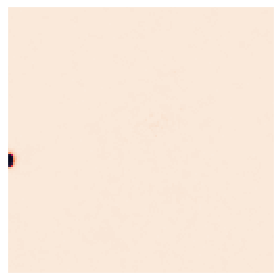

0.9967594146728516


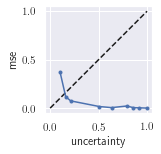

(1, 50000)
SGLD+NLL $\sigma=\eta$
max psnr: 27.47
2005
26.342002810776826
max psnr last 100: 23.71
mean psnr: 23.68
std psnr: 0.0138


max ssim: 0.87
max ssim last 100: 0.72
mean ssim: 0.71
std ssim: 0.0009


mean mse: 0.00328
std: 0.0001


uncert mean: 99.91221
uncert std: 0.00000
uce mean: 9967.59415
uce std: 0.00000





In [5]:
for run, label in zip(runs, labels):
    # check wether this and extensions with _1, _2, ... exists
    dir_names = [file for file in files if file[:len(run)] == run and file[len(run):] in ['', '_1', '_2', '_3']]
    print(dir_names)
    psnrs = []
    ssims = []
    
    mses = []
    
    uces = []
    uncerts = []
    
    for dir_name in dir_names:
        net_info = json.load(open('%s/%s/net_info.json' % (path_log_dir, dir_name)))
        train_data = torch.load('%s/%s/train_vals.pt' % (path_log_dir, dir_name))
        image_data = np.load('%s/%s/vals.npz' % (path_log_dir, dir_name))
        img_np_noisy = pil_to_np(Image.open('%s/%s/noisy_img.png' % (path_log_dir, dir_name)))
        bay_inf_type = net_info['bay_inf_type']
        
        psnrs.append(train_data['psnr_gt_sm'])
        ssims.append(train_data['ssim_gt_sm'])
        mses.append(train_data['mse'])
        
        net = get_trained_net(net_info, train_data)
        
        net_input_np = image_data['net_input']
        net_input = torch.from_numpy(net_input_np).type(dtype)#.unsqueeze(0)
        img_noisy_torch = torch.from_numpy(img_np_noisy).unsqueeze(0).type(dtype)
        
        _uncerts = []
        _uces = []
        
        if bay_inf_type in ['sgld', 'sgld_paper']:
            samples = [pil_to_np(Image.open('%s/%s/%s' % (path_log_dir, dir_name, fname))) for fname in os.listdir('%s/%s' % (path_log_dir, dir_name)) if fname[:6] == 'sample']
            if net_info['criterion'] == 'mse':
                uncert = np.var(np.mean(np.array(samples)[:,:-1], axis=1), axis=0)
                print(uncert.dtype)
                print(uncert.max())
                print(uncert.mean())
            elif net_info['criterion'] == 'nll':
                epi = np.var(np.mean(np.array(samples)[:,:-1], axis=1), axis=0)
                ale = np.mean(np.mean(np.array(samples)[:,-1:], axis=1), axis=0)
                uncert = ale +epi
                
                plt.imshow(ale)
                plt.grid(False)
                plt.yticks([])
                plt.xticks([])
                plt.tight_layout()
                #plt.savefig('imgs/%s.png' % label, bbox_inches='tight')
                plt.show()
                
                plt.imshow(epi)
                plt.grid(False)
                plt.yticks([])
                plt.xticks([])
                plt.tight_layout()
                #plt.savefig('imgs/%s.png' % label, bbox_inches='tight')
                plt.show()
                
            plt.imshow(uncert)
            plt.grid(False)
            plt.yticks([])
            plt.xticks([])
            plt.tight_layout()
            plt.savefig('imgs/%s.png' % label, bbox_inches='tight')
            plt.show()

            uncert = torch.from_numpy(uncert).unsqueeze(0).unsqueeze(0)

            mean = np.mean(np.array(samples)[:,:-1], axis=0)
            out_torch_mean = torch.from_numpy(mean).unsqueeze(0)

            mse_err = F.mse_loss(out_torch_mean, img_noisy_torch.cpu(), reduction='none')
            mse_err = mse_err.mean(dim=1, keepdim=True)

            uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert)
            uncerts.append([uncert.mean().item()])
            uces.append([uce.item()])
            print(uce.item())

            V.plot_uncert(err_in_bin.cpu(), avg_sigma_in_bin.cpu())
            plt.tight_layout()
            #plt.savefig('imgs/sgld_den_xray_calib.png', bbox_inches='tight')
            plt.show()
                
        else:
            for k in range(5):
                img_list = []

                with torch.no_grad():
                    for _ in range(mc_iter):
                        img = net(net_input)
                        img[:,:-1] = img[:,:-1].sigmoid()
                        img[:,-1:] = torch.exp(-torch.clamp(img[:,-1:], min=-20, max=20))
                        img_list.append(img)

                ale, epi, uncert = uncert_regression_gal(img_list, reduction='none')

                out_torch_mean = torch.mean(torch.cat(img_list, dim=0)[:], dim=0, keepdim=True)

                mse_err = F.mse_loss(out_torch_mean[:,:-1], img_noisy_torch, reduction='none')
                mse_err = mse_err.mean(dim=1, keepdim=True)

                uce, err_in_bin, avg_sigma_in_bin, freq_in_bin = uceloss(mse_err, uncert)

                _uces.append(uce.cpu().item())
                _uncerts.append(uncert.cpu().mean().item())
            uncerts.append(_uncerts)
            uces.append(_uces)
    
    print(np.array(psnrs).shape)
    psnrs = np.array(psnrs)
    mses = np.array(mses)
    ssims = np.array(ssims)
    print(label)
    print('max psnr: %.2f' % psnrs.max())
    print(np.argmax(psnrs))
    print(psnrs.mean(axis=0)[1000])
    print('max psnr last 100: %.2f' % psnrs[:,-100:].max())
    print('mean psnr: %.2f' % psnrs[:,-100:].mean())
    print('std psnr: %.4f' % np.std(psnrs[:,-100:].mean(axis=0)))
    print('\n')
    
    print('max ssim: %.2f' % ssims.max())
    print('max ssim last 100: %.2f' % ssims[:,-100:].max())
    print('mean ssim: %.2f' % ssims[:,-100:].mean())
    print('std ssim: %.4f' % np.std(ssims[:,-100:].mean(axis=0)))
    print('\n')
    
    print('mean mse: %.5f' % mses[:,-100:].mean())
    print('std: %.4f' % np.std(mses[:,-100:].mean(axis=0)))
    print('\n')
    
    uncerts = np.array(uncerts)
    uces = np.array(uces)
    uncert_mean = np.sqrt(np.mean(uncerts)) * 100
    uncert_std = np.sqrt(np.std(uncerts.mean(axis=0))) * 100
    print('uncert mean: %.5f' % uncert_mean)
    print('uncert std: %.5f' % uncert_std)
    uce_mean = np.mean(uces) * 100 * 100
    uce_std = np.std(uces.mean(axis=0)) * 100 * 100
    print('uce mean: %.5f' % uce_mean)
    print('uce std: %.5f' % uce_std)
    print('\n\n')

In [6]:
uncerts = np.array([10.42, 10.28, 9.8, 6.91, 7.72])
print(np.mean(uncerts))
print(np.std(uncerts))

uncerts = np.array([9.67, 9.41, 13.67, 7.28, 8.26])
print(np.mean(uncerts))
print(np.std(uncerts))

uncerts = np.array([10.24, 10.44, 9.47, 7.29, 7.97])
print(np.mean(uncerts))
print(np.std(uncerts))

uncerts = np.array([9.84, 9.82, 9.19, 6.65, 7.57])
print(np.mean(uncerts))
print(np.std(uncerts))

9.026
1.4351250816566479
9.658
2.1802330150697196
9.081999999999999
1.247676240055889
8.614
1.2834734122684426


In [7]:
uces = np.array([7.2, 12.36, 5.84, 7.78, 6.87])
print(np.mean(uces))
print(np.std(uces))

uces = np.array([3.19, 3.59, 81.53, 2.47, 2.54])
print(np.mean(uces))
print(np.std(uces))

uces = np.array([8.16, 14.44, 4.98, 7.28, 7.05])
print(np.mean(uces))
print(np.std(uces))

uces = np.array([7.02, 8.36, 4.92, 4.98, 4.78])
print(np.mean(uces))
print(np.std(uces))

8.01
2.2645087767549055
18.664
31.435753911748325
8.382
3.203463126055925
6.012
1.4355821118974694
